In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats.multivariate_normal as mvn
import autograd.scipy.stats.norm as norm

from autograd import grad
from autograd.optimizers import adam
from black_box_svi import black_box_variational_inference

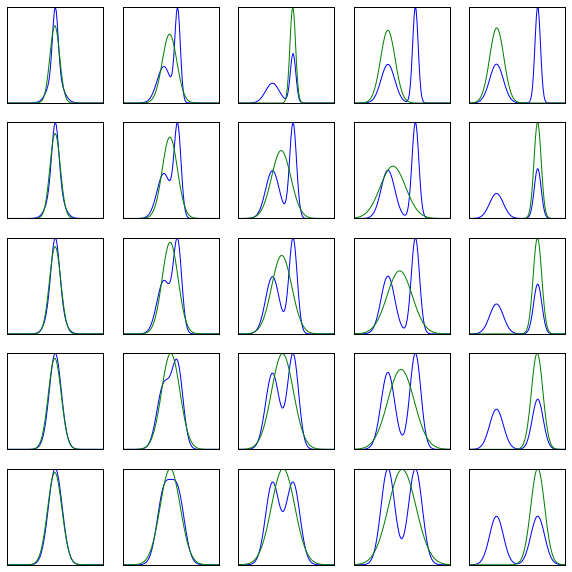

In [4]:
# an example showing variational compactness is not true in all cases
# see: Two problems with variational expectation maximisation for time-series models
# Richard E. Turner and Maneesh Sahani

D = 1
# Set up plotting code
def plot_pdf(ax, func, xlimits=[-7, 7], numticks=101):
    x = np.linspace(*xlimits, num=numticks)
    zs = func(np.atleast_2d(x.ravel()).T)
    Z = zs.reshape(x.shape)
    ax.plot(x, Z)
#     ax.set_ylim([0, 1.5])
    ax.set_xlim(xlimits)
    ax.set_xticks([])
    ax.set_yticks([])
        
def plot_results(ax, params, target_posterior):
    plot_pdf(ax, target_posterior)
    mean, log_std = unpack_params(params)
    variational_contour = lambda x: mvn.pdf(x, mean, np.diag(np.exp(2*log_std)))
    plot_pdf(ax, variational_contour)
    
ratios = [0.4, 0.5, 0.6, 0.8, 1]
deltas = [0, 2, 3, 4, 6]
# Set up figure.
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
for i, r in enumerate(ratios):
    for j, delta in enumerate(deltas):
        def target_posterior(x):
            a = 1
            gauss1 = 0.5 * norm.pdf(x, -delta/2, a)
            gauss2 = 0.5 * norm.pdf(x, delta/2, a*r)
            return gauss1 + gauss2
        
        def log_density(x, t):
            return np.log(target_posterior(x))

        # Build variational objective.
        objective, gradient, unpack_params = \
            black_box_variational_inference(log_density, 1, num_samples=50)

        init_mean    = np.random.randn(D)
        init_log_std = -2 * np.ones(D)
        init_var_params = np.concatenate([init_mean, init_log_std])
        variational_params = adam(gradient, init_var_params, step_size=0.1, num_iters=200)
        plot_results(axs[i, j], variational_params, target_posterior)